In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch

from src.nn_datasets.eeg_datamodule import EEGDataModule
from src.nn_augs.eeg_transforms import *
from src.nn_models.litmodels import LitModel
from src.nn_datasets.eegdataset import load_eeg_data

In [2]:
def plot_batch(batch_x, batch_y, preds=None):
    batch_x = batch_x[:8].numpy()
    batch_y = batch_y[:8].numpy()
    if preds is not None:
        preds = preds[:8]
    fig, axs = plt.subplots(2, 4, figsize=(12, 12))
    for i in range(8):
        ax = axs[i // 4, i % 4]
        offset = 0
        for j in range(16):
            if j != 0:
                offset -= batch_x[i, :, j].min()
            ax.plot(batch_x[i, :, j] + offset)
            offset += batch_x[i, :, j].max() + 1
        y_str = " ".join([f"{y:.1f}" for y in batch_y[i]])
        ax.set_title(f"y={y_str}")
        if preds is not None:
            pred_str = " ".join([f"{y:.1f}" for y in preds[i]])
            ax.text(0, offset, f"pred={pred_str}")
    plt.show()


def plot_zoomed_batch(batch_x, batch_y, start=0, n=100):
    batch_x = batch_x[:8].numpy()
    batch_y = batch_y[:8].numpy()
    fig, axs = plt.subplots(2, 4, figsize=(12, 12))
    for i in range(8):
        ax = axs[i // 4, i % 4]
        offset = 0
        for j in range(16):
            if j != 0:
                offset -= batch_x[i, start : start + n, j].min()
            ax.plot(batch_x[i, start : start + n, j] + offset)
            offset += batch_x[i, start : start + n, j].max() + 1
        y_str = " ".join([f"{y:.1f}" for y in batch_y[i]])
        ax.set_title(f"y={y_str}")
    plt.show()

In [3]:
dm = EEGDataModule(
    "./data",
    batch_size=8,
    num_folds=5,
    fold_id=0,
    num_workers=0,
    pin_memory=False,
    transforms=[
        SideSwap(1.0),
    ],
)
dm.setup("fit")

In [4]:
tr_dl = dm.train_dataloader()
vl_dl = dm.val_dataloader()

In [5]:
tr_dl_iter = iter(tr_dl)
batch_x, batch_y = next(tr_dl_iter)

In [6]:
vl_dl_iter = iter(vl_dl)
batch_x_vl, batch_y_vl = next(vl_dl_iter)

In [75]:
batch_x_vl, batch_y_vl = next(vl_dl_iter)

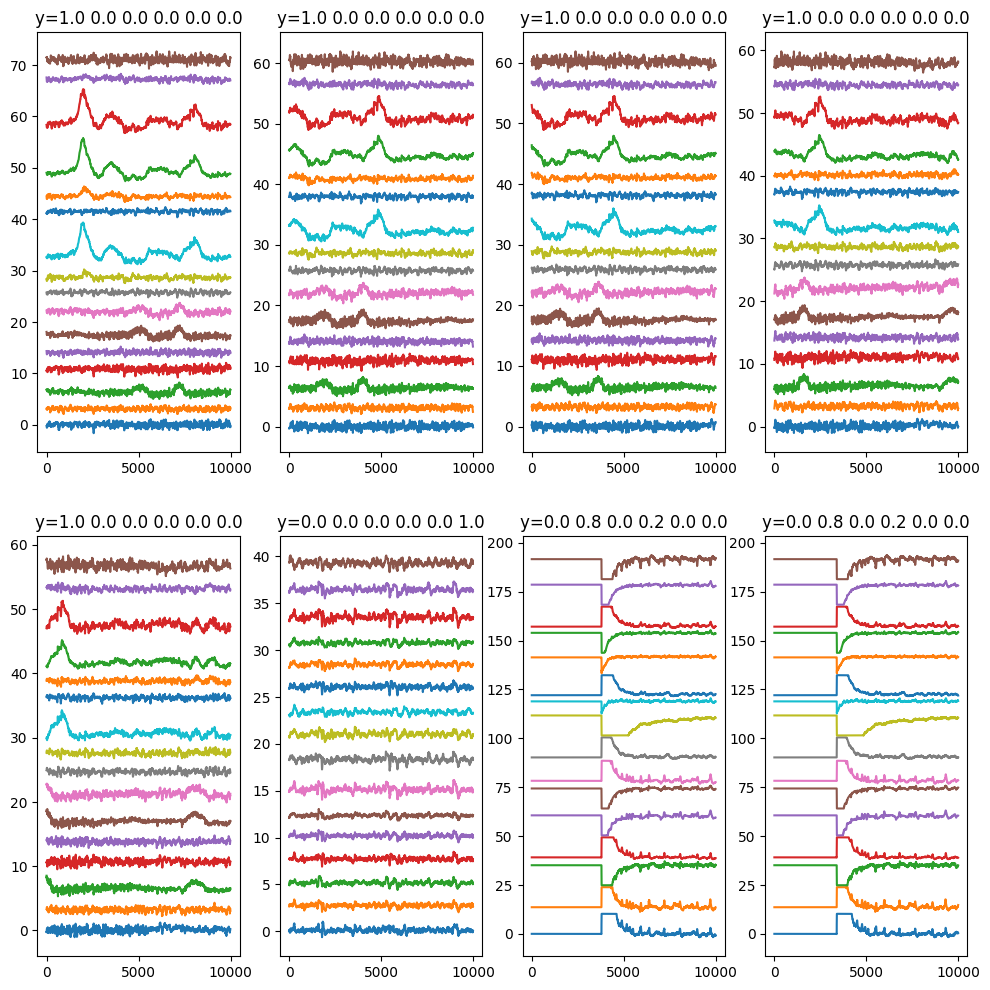

In [47]:
plot_batch(batch_x_vl, batch_y_vl)

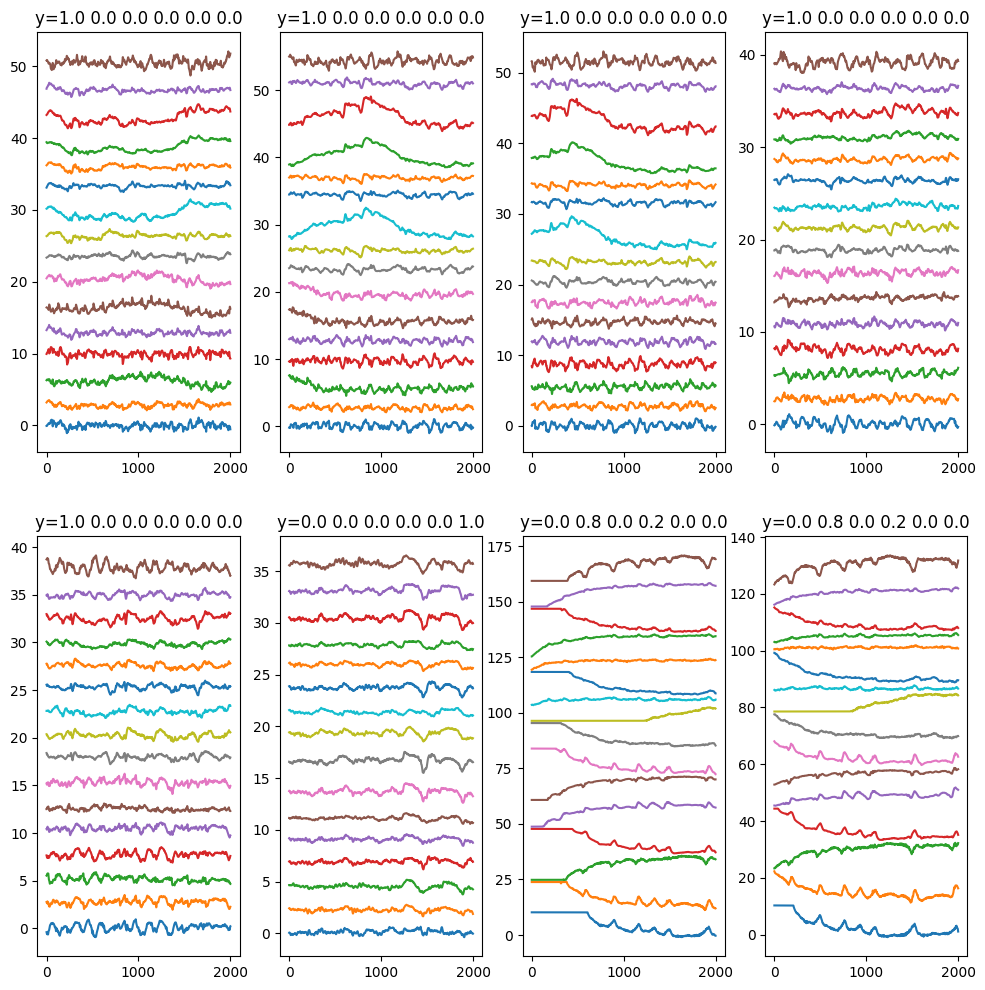

In [48]:
plot_zoomed_batch(batch_x_vl, batch_y_vl, 4000, 2000)

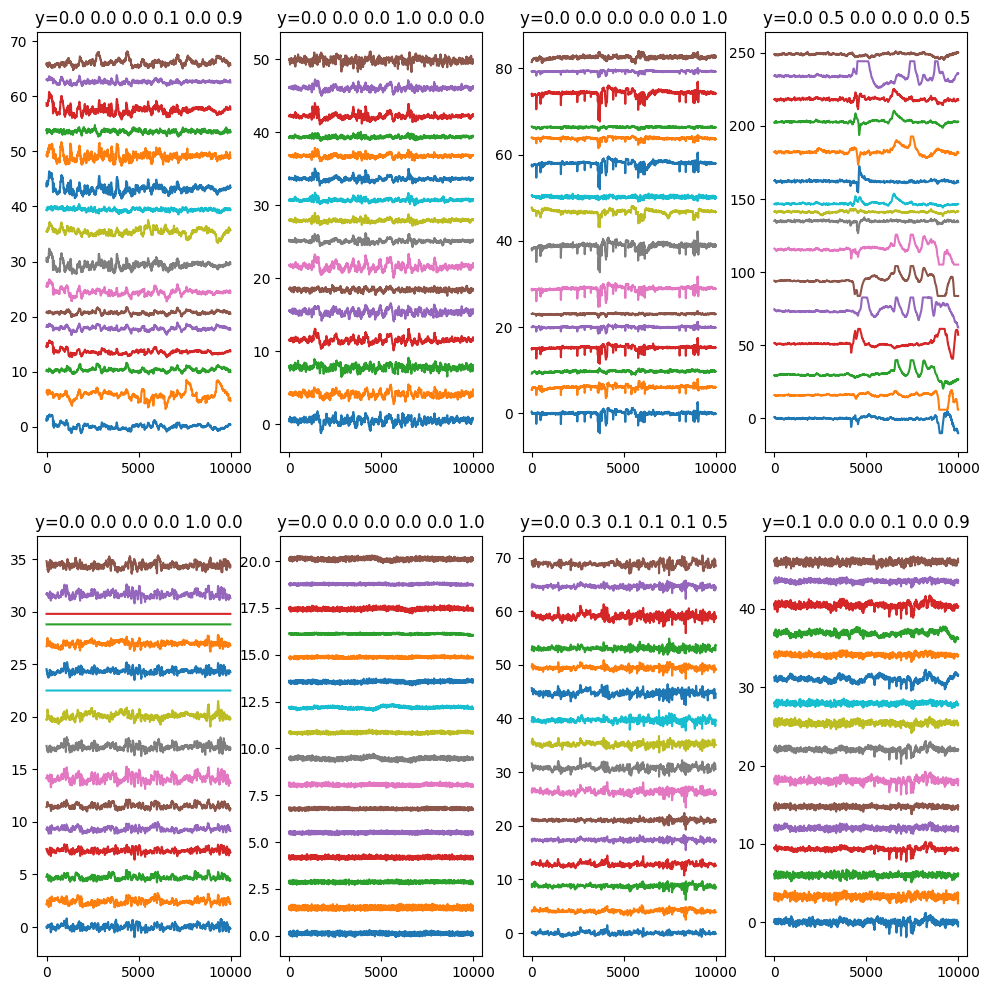

In [49]:
plot_batch(batch_x, batch_y)

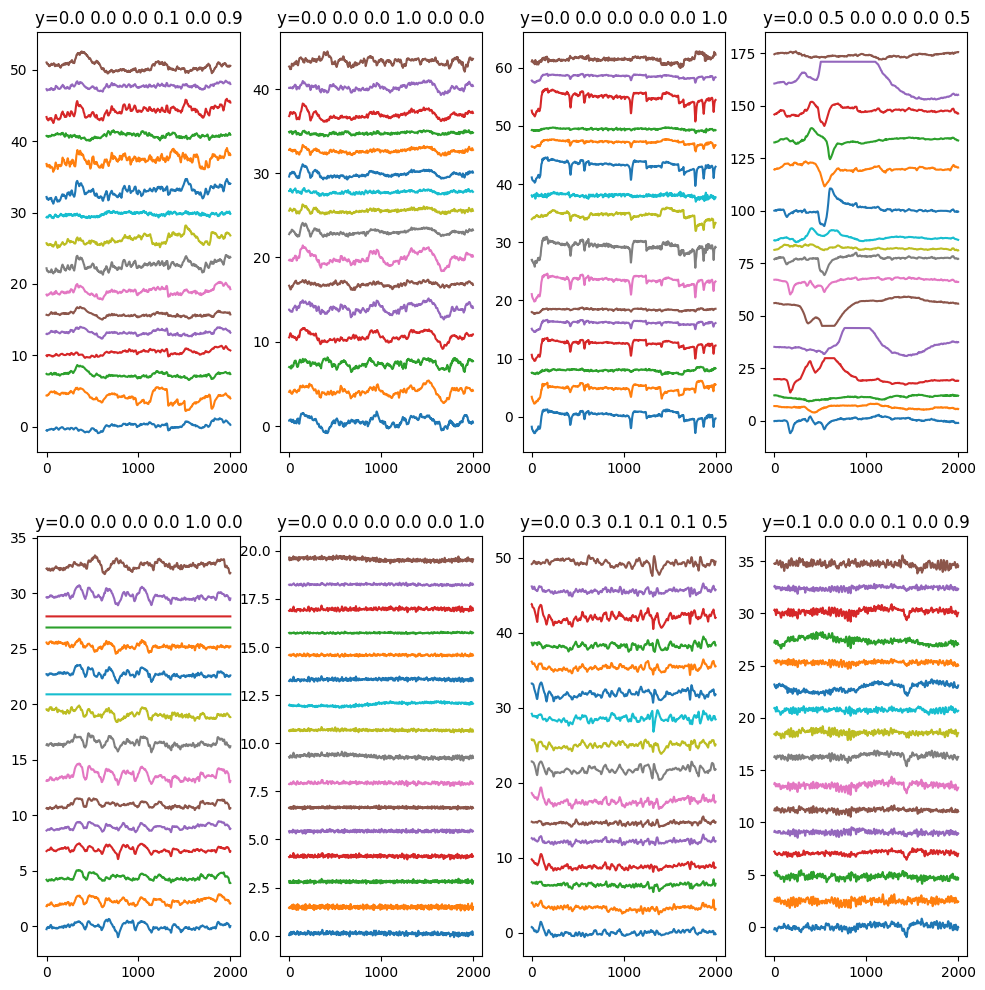

In [22]:
plot_zoomed_batch(batch_x, batch_y, 4000, 2000)

In [92]:
dm.data_val.df[8 * 54]

shape: (1, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ eeg_id    ┆ eeg_sub_i ┆ eeg_label ┆ spectrogr ┆ … ┆ lrda_vote ┆ grda_vote ┆ other_vot ┆ num_vote │
│ ---       ┆ d         ┆ _offset_s ┆ am_id     ┆   ┆ ---       ┆ ---       ┆ e         ┆ s        │
│ i64       ┆ ---       ┆ econds    ┆ ---       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---      │
│           ┆ i64       ┆ ---       ┆ i64       ┆   ┆           ┆           ┆ f64       ┆ i64      │
│           ┆           ┆ f64       ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 859827913 ┆ 11        ┆ 150.0     ┆ 43981257  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 19       │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [93]:
tmp = pl.read_parquet("./data/train_eegs/859827913.parquet")
tmp

shape: (42_400, 20)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬──────┐
│ Fp1        ┆ F3         ┆ C3         ┆ P3         ┆ … ┆ T4        ┆ T6        ┆ O2        ┆ EKG  │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---  │
│ f32        ┆ f32        ┆ f32        ┆ f32        ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32  │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪══════╡
│ -21.799999 ┆ -6.11      ┆ -9.57      ┆ -5.58      ┆ … ┆ -3.72     ┆ 18.08     ┆ 20.469999 ┆ 5.85 │
│ -34.560001 ┆ -18.34     ┆ -23.389999 ┆ -18.610001 ┆ … ┆ -16.21999 ┆ 5.58      ┆ 7.71      ┆ 6.12 │
│            ┆            ┆            ┆            ┆   ┆ 9         ┆           ┆           ┆      │
│ -30.309999 ┆ -16.75     ┆ -23.389999 ┆ -19.67     ┆ … ┆ -20.20000 ┆ 0.0       ┆ 2.13      ┆ 2.92 │
│            ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆           ┆      │
│ -17.280001 ┆ -4.79      ┆ -13.03     ┆ -9.3       ┆ … ┆ -13.82    ┆ 6.38      ┆ 9.04      ┆ 8.51 │
│ -20.74     ┆ -5.05      ┆ -12.49     ┆ -6.91      ┆ … ┆ -10.63    ┆ 10.1      ┆ 10.1      ┆ 9.04 │
│ …          ┆ …          ┆ …          ┆ …          ┆ … ┆ …         ┆ …         ┆ …         ┆ …    │
│ 62.740002  ┆ 0.0        ┆ -26.049999 ┆ -26.58     ┆ … ┆ -38.81000 ┆ -7.44     ┆ -8.24     ┆ 2.39 │
│            ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆           ┆      │
│ 63.27      ┆ -2.39      ┆ -26.049999 ┆ -26.32     ┆ … ┆ -45.99000 ┆ -10.63    ┆ -11.17    ┆ 4.25 │
│            ┆            ┆            ┆            ┆   ┆ 2         ┆           ┆           ┆      │
│ 57.950001  ┆ -6.65      ┆ -26.32     ┆ -22.33     ┆ … ┆ -42.27    ┆ -6.38     ┆ -9.04     ┆ 4.52 │
│ 50.779999  ┆ -6.65      ┆ -20.74     ┆ -17.549999 ┆ … ┆ -42.52999 ┆ -4.52     ┆ -8.51     ┆ 4.78 │
│            ┆            ┆            ┆            ┆   ┆ 9         ┆           ┆           ┆      │
│ 42.0       ┆ -18.870001 ┆ -32.169998 ┆ -30.040001 ┆ … ┆ -51.57    ┆ -17.28000 ┆ -22.33    ┆ 3.46 │
│            ┆            ┆            ┆            ┆   ┆           ┆ 1         ┆           ┆      │
└────────────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴──────┘

In [94]:
import plotly.express as px
from src.nn_datasets.eegdataset import butter_lowpass_filter

sig = (tmp["EKG"]).to_numpy()
sig = butter_lowpass_filter(sig)
# sig = np.sqrt(np.abs(sig)) * np.sign(sig)
px.line(sig[78 * 200 : 78 * 200 + 10000])

In [15]:
#tmp2 = np.load("./data/train_eegs/352528627_4.npy")
#tmp2 = butter_lowpass_filter(tmp2)
#sig = tmp2[:, 11] - tmp2[:, 13]

# sig = np.log1p(np.abs(sig)) * np.sign(sig)
px.line(sig)

In [95]:
model = LitModel.load_from_checkpoint(
    "./logs/train/runs/2024-03-13_16-16-11/checkpoints/last.ckpt"
)

/home/mohsin/testing/hms_benchmark/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: UserWarning:

Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.



In [96]:
model.eval()
model.cuda()
with torch.no_grad():
    preds = model(batch_x_vl.cuda())
    preds = torch.nn.functional.softmax(preds, dim=1)
    preds = preds.cpu().numpy()

preds

array([[0.67463547, 0.06975135, 0.00201374, 0.1363697 , 0.00902462,
        0.10820515],
       [0.72239363, 0.05383806, 0.00172108, 0.1249782 , 0.00913952,
        0.08792952],
       [0.71299374, 0.05960196, 0.00158371, 0.13340558, 0.00985347,
        0.08256156],
       [0.70301056, 0.05809143, 0.00151657, 0.14388148, 0.01382421,
        0.07967577],
       [0.720028  , 0.0661212 , 0.00129011, 0.11840683, 0.00954886,
        0.08460505],
       [0.74387586, 0.06118699, 0.00178013, 0.10562559, 0.00997122,
        0.07756021],
       [0.782812  , 0.04892087, 0.0009587 , 0.10227098, 0.00834182,
        0.05669564],
       [0.58085   , 0.0793439 , 0.00222507, 0.14448012, 0.02159048,
        0.1715104 ]], dtype=float32)

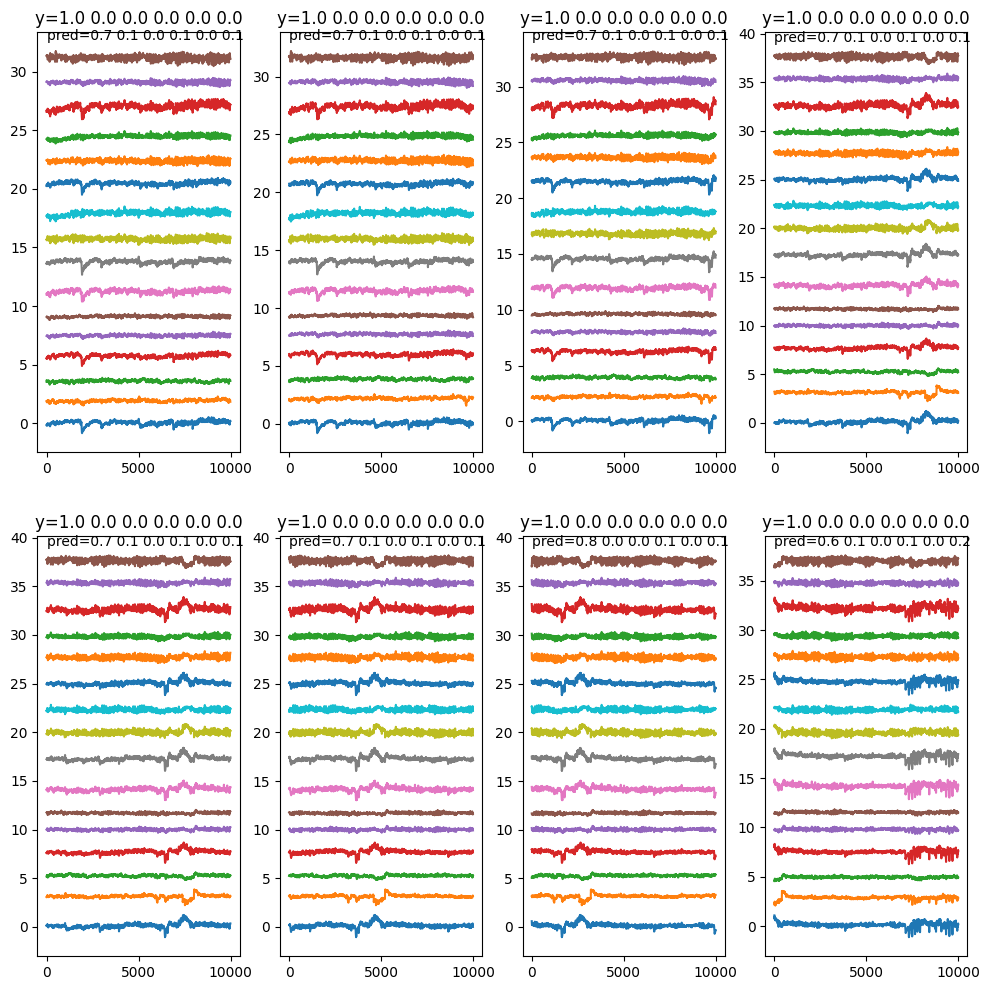

In [97]:
plot_batch(batch_x_vl, batch_y_vl, preds)

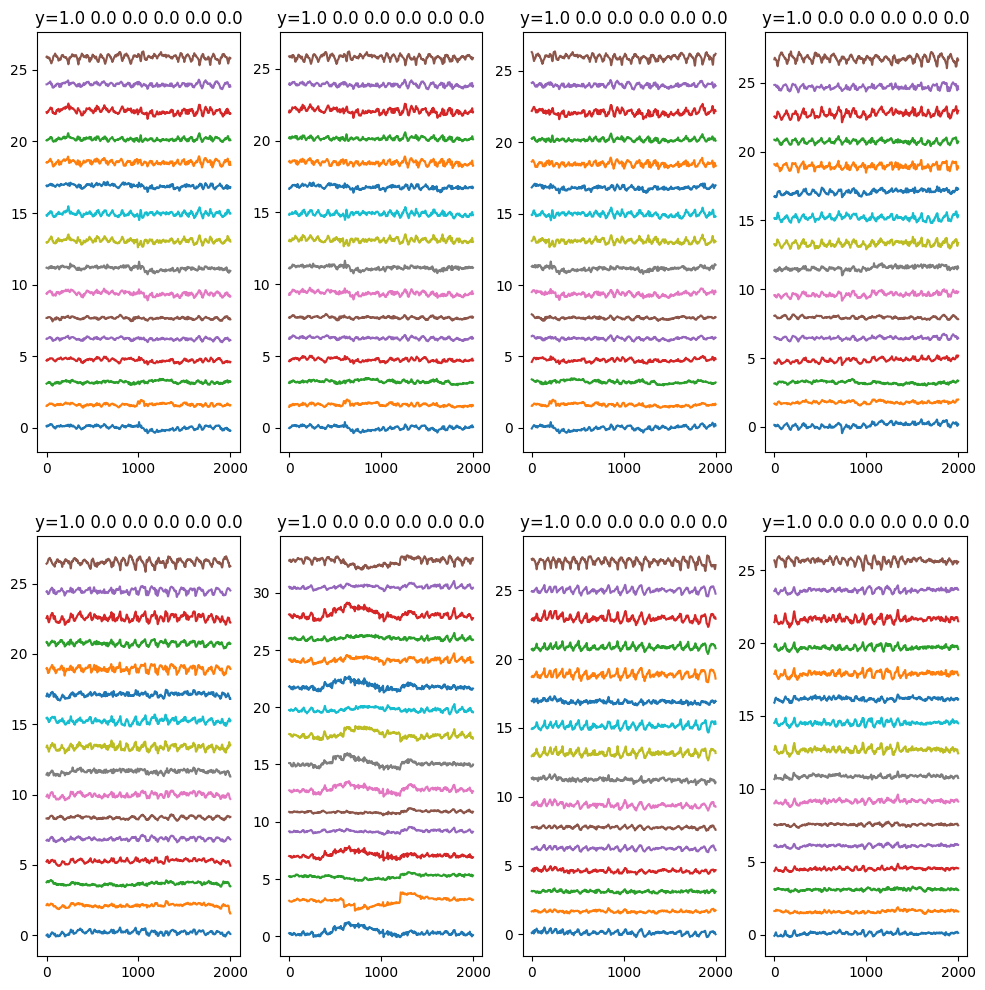

In [98]:
plot_zoomed_batch(batch_x_vl, batch_y_vl, 4000, 2000)

In [21]:
from src.settings import TARGET_COLS

TARGET_COLS

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']